In [ ]:
#TP encadré par Joseph Gergaud

<center>
<h1> Résolution de l'équation de la chaleur par discrétisation différences finies en temps et en espace</h1>

</center>

## Objectifs 

<br>
Nous souhaitons résoudre le problème de la chaleur muni de conditions limites de type Dirichlet homogènes suivant:
<br>    
$$ (P)~ \left \{
        \begin{array}{11}
            \ \displaystyle \frac{\partial u}{\partial t}-\Delta u = f \, \, \, \, \, \, (\Omega \times [0, T])\\
            \ u(0,t)=0 \, \, \, \, \, \, (\partial \Omega) \\
            \ u(1,t)=0 \, \, \, \, \, \, (\partial \Omega) \\
            \ u(x,0)=u_{0}(x) \, \, \, \, \, \, (t=0)
         \end{array} 
         \right. $$
<br> 
sur un domaine monodimensionnel $\Omega$ par une méthode de discrétisation de type différences finies.  Nous vous proposons de détailler pas à pas les différentes étapes en réalisant 
systématiquement des tests unitaires afin de valider vos implantations.<br>  

Les étapes proposées sont les suivantes:<br>
- Imposer une solution exacte $ u_{ex}(x,t)$ au problème $(P)$. 
- En déduire une condition initiale $ u_{0}(x)$ au problème $(P)$. 
- En déduire $f$ le terme source associé à $ u_{ex}(x,t)$. 
- Résoudre numériquement $(P)$ en utilisant les schémas d'Euler explicite et implicite. 
- Déterminer numériquement l'ordre de convergence des schémas de discrétisation en temps. 



### Import des librairies Python nécessaires

In [1]:
import scipy as sc
import scipy.sparse as sparse
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
import math

### Définition des paramètres du problème (P)

In [2]:
# Nombre de pas de discretisation en temps 
N_t = 300
# Nombre de pas de discretisation en espace 
M = 10
# Nombre de points de discretisation en espace
N = M + 1
# Temps final [s]
T = 1
# Pas de discretisation temporel sur [0 T]
delta_t = T/N_t
# Pas de discretisation spatial sur le domaine [0,1]
h = 1/(N-1)
# Nombre CFL 
c = delta_t / h**2
c

0.3333333333333333

### Définition de la fonction solution exacte choisie, du second membre de l'équation de la chaleur et déduction du schéma de construction associé à la solution exacte 

In [3]:
def solution_exacte(x,t):
    """
    Fonction representant la solution exacte du probleme de la chaleur. 
    Cette fonction doit verifier les conditions initiales et limites sur 
    la frontiere du domaine. 
    Entrees:
    x: abscisse du point de maillage [float]
    t: temps discret considere [float]
    Sortie:
    Valeur de la solution exacte evaluee en x et au temps t [float]
    """
    return -x*(x-1) * np.exp(t)

def second_membre(x, t):
    """
    Fonction representant le second membre associe a la solution exacte du probleme 
    de la chaleur.  
    Entrees:
    x: abscisse du point de maillage [float]
    t: temps discret considere [float]
    Sortie:
    Valeur du second membre evalue en x et au temps t [float]
    """
    return -(x*(x-1) - 2) * np.exp(t)

def schema_exact(N, h, c, T, delta_t, u0):
    """
    Fonction representant le tableau bidimensionnel [espace, temps] correspondant a la 
    solution en chaque point du maillage et a tout temps discret.
    Entrees:
    N: Nombre de points de discretisation en espace [int]
    h: Pas de maillage spatial [float]
    c: Nombre CFL [float]
    T: Temps final [float]
    delta_t: Pas de discretisation temporel [float]
    u0: condition initiale [array]
    Sortie:
    U_exacte: Tableau bidimensionnel de la solution evaluee en tout x et a tout temps t [float]
    """
    # Initialisation de la solution 
    U_exact = np.zeros((N, int(T/delta_t)))
    # Prise en compte de la solution initiale
    U_exact[:, 0] = u0
    # Prise en compte des condition aux limites
    U_exact[0, :] = 0
    U_exact[N-1, :] = 0
    # Deduction de la solution aux autres instants 
    for t in range(1, int(T/delta_t)) :
        for k in range(1, N-1) :
            U_exact[k,t] = solution_exacte(k*h,t*delta_t)
    return U_exact

    
    
    
    
#le nombre CFL n'est pas utile dans le calcul 

### Définition de la condition initiale et affichage de la solution exacte pour différents instants 

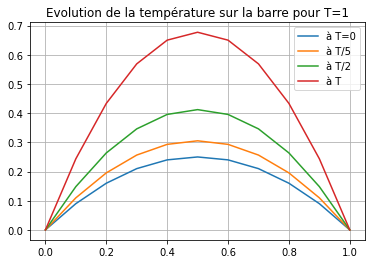

In [4]:
#
# Definition de la condition initiale comme un tableau monodimensionnel en espace
#
#u0  = np.zeros(N, dtype=float)
u0 = np.array([-x*(x-1) for x in np.arange(0,1+h,h)])
# A COMPLETER pour avoir votre condition initiale

#
# Deduction de la solution exacte par appel de la fonction schema_exact
#
U = schema_exact(N, h, c, T, delta_t, u0)
#
# Representation graphique a differents instants a choisir
#
x = np.linspace(0, 1, N)
plt.plot(x, U[:,0], label="à T=0")
plt.plot(x, U[:, int(N_t/5)], label="à T/5")
plt.plot(x, U[:, int(N_t/2)], label="à T/2")
plt.plot(x, U[:,int(T/delta_t)-1], label="à T" )
plt.legend()
plt.grid(True)
plt.title("Evolution de la température sur la barre pour T=" + str(T))
plt.show()

### Construction du schéma explicite en temps

In [5]:
def schema_explicite(N, h, c, T, delta_t, U_explicite):
    """
    Fonction representant le tableau bidimensionnel [espace, temps] correspondant a la 
    solution en chaque point du maillage et a tout temps discret obtenue avec le schema 
    explicite.
    Entrees:
    N: Nombre de points de discretisation en espace [int]
    h: Pas de maillage spatial [float]
    c: Nombre CFL [float]
    T: Temps final [float]
    delta_t: Pas de discretisation temporel [float]
    u0: condition initiale [array]
    Sortie:
    U_explicite: Tableau bidimensionnel de la solution du schema explicite evaluee en tout x et a tout temps t [float]
    """
    #
    # Création de la matrice A via une matrice creuse (interieur du domaine)
    #
    A = np.zeros((N-2, N-2))
    A[0,0] = 1 - 2 * c
    for i in range(1, N-2) :
        A[i,i] = 1 - 2 * c
        A[i,i-1] = c
        A[i-1,i] = c

    #
    # Application du schéma sur les points interieurs (d'où la suppression des premier et dernier éléments)
    #  
    for t in range(1, int(T/delta_t)) :
        U_explicite[1:-1,t] = np.dot(A,U_explicite[1:-1,t-1]) + delta_t * second_membre(np.arange(0,1+h,h)[1:-1],(t-1)*delta_t)
    return U_explicite

### Affichage de la solution discrète pour le schéma explicite pour différents instants 

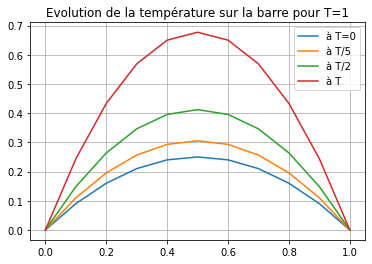

In [6]:
#
# La condition initiale est celle qui a été définie ci-dessus

#
# Deduction de la solution du schema explicite en temps
#
U_explicite      = np.zeros((N, int(T/delta_t)), dtype=float)
U_explicite[:,0] = u0
Ue               = schema_explicite(N,h,c, T, delta_t, U_explicite)
#
# Representation graphique a differents instants a choisir
#
x = np.linspace(0, 1, N)
plt.plot(x, Ue[:,0], label="à T=0")
plt.plot(x, Ue[:, int(N_t/5)], label="à T/5")
plt.plot(x, Ue[:, int(N_t/2)], label="à T/2")
plt.plot(x, Ue[:,int(T/delta_t)-1], label="à T" )
plt.legend()
plt.grid(True)
plt.title("Evolution de la température sur la barre pour T=" + str(T))
plt.show()


### Construction du  schéma implicite en temps

In [7]:
def schema_implicite(N,h,c, T, delta_t, U_implicite):
    """
    Fonction representant le tableau bidimensionnel [espace, temps] correspondant a la 
    solution en chaque point du maillage et a tout temps discret obtenue avec le schema 
    explicite.
    Entrees:
    N: Nombre de points de discretisation en espace [int]
    h: Pas de maillage spatial [float]
    c: Nombre CFL [float]
    T: Temps final [float]
    delta_t: Pas de discretisation temporel [float]
    u0: condition initiale [array]
    Sortie:
    U_implicite: Tableau bidimensionnel de la solution du schema implicite evaluee en tout x et a tout temps t [float]
    """
    #
    # Création de la matrice B via une matrice creuse (interieur du domaine)
    #
    B = np.zeros((N-2, N-2))
    B[0,0] = 1 + 2 * c
    for i in range(1, N-2) :
        B[i,i] = 1 + 2 * c
        B[i,i-1] = -c
        B[i-1,i] = -c

    #
    # Application du schéma sur les points interieurs
    #
    #U_implicite[:,0] = u0
    #U_implicite[0,:] = 0
    #U_implicite[N-1,:] = 0
        
    for t in range(1, int(T/delta_t)):
        U_implicite[1:-1,t] = np.linalg.solve(B, U_implicite[1:-1,t-1] + delta_t * second_membre(np.arange(0,1+h,h)[1:-1],t*delta_t))
    
    return U_implicite

### Affichage de la solution discrète pour le schéma implicite pour différents instants 

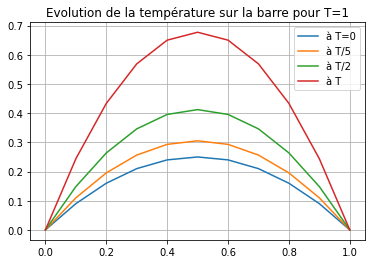

In [8]:
#
# La condition initiale est celle qui a été définie ci-dessus

#
# Deduction de la solution du schema implicite en temps
#
U_implicite      = np.zeros((N, int(T/delta_t)), dtype=float)
U_implicite[:,0] = u0
Ui               = schema_implicite(N,h,c, T, delta_t, U_implicite)
#
# Representation graphique a differents instants a choisir
#
x = np.linspace(0, 1, N)
plt.plot(x, Ui[:,0], label="à T=0")
plt.plot(x, Ui[:, int(N_t/5)], label="à T/5")
plt.plot(x, Ui[:, int(N_t/2)], label="à T/2")
plt.plot(x, Ui[:,int(T/delta_t)-1], label="à T" )
plt.legend()
plt.grid(True)
plt.title("Evolution de la température sur la barre pour T=" + str(T))
plt.show()

### Détermination de l'ordre de convergence des schémas de discrétisation en temps

In [9]:
def erreur(U_exacte, U, h):
    """
    Calcul de l'erreur discrete 
    Entrees:
    U_exacte: solution exacte du probleme considere [float]
    U       : solution discrete pour un schema donne [float]
    h       : pas de discretisation spatial [float]
    Sortie: 
    norme de l'erreur discrete [float]
    """
    return np.max(np.sqrt(np.sum((U_exacte - U)**2, 0)*h))

In [10]:
def ordre_discretisation_temps(h, N, T):
    """
    Calcul de l'ordre de discretisation en temps
    Entrées : 
        h: pas de discretisation spatial  [float]
        N: nombre de points de discretisation en espace [int]
        T: temps final [float]
    Sortie : 
        time_step: pas de temps en loi log [float, array]
        erreur  : erreur en loi log[float, array]
    """
    time_step = np.zeros(10)
    error     = np.zeros(10)
    count     = 0
    
    for loop in range(20, 120, 10):
        delta = 1./loop
        c     = delta/(h**2)
        #
        # Initialisation pour la solution exacte
        #
        #u0       = np.zeros(N, dtype=float)
        u0 = np.array([-x*(x-1) for x in np.arange(0,1+h,h)])

        U_exacte = schema_exact(N, h, c, T, delta, u0)          
        #
        # Initialisation pour la solution numérique
        #
        U_implicite   = np.zeros((N, int(T/delta)), dtype=float)
        #u0            = np.zeros(N, dtype=float)
        U_implicite[:,0] = u0
        #
        #
        #
        U_implicite      = schema_implicite(N, h, c, T, delta, U_implicite)
        error[count]     = math.log(erreur(U_exacte, U_implicite, h))
        time_step[count] = math.log(delta) 
        count            += 1
        
    return time_step, error

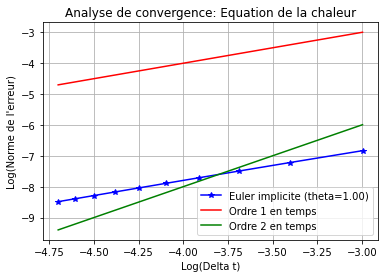

In [11]:
#
# Construction des elements pour l'analyse du schema
#
time_step, error  = ordre_discretisation_temps(h, N, T)

#
# Creation de la figure
#
theta = 1.0
fig = plt.figure()
plt.plot(time_step,error,marker='*',color='blue',label='Euler implicite (theta='"%3.2f"%theta+')')
plt.plot(time_step,1.*time_step,color='red',label='Ordre 1 en temps')
plt.plot(time_step,2.*time_step,color='green',label='Ordre 2 en temps')
plt.xlabel("Log(Delta t)")
plt.ylabel("Log(Norme de l'erreur)")
plt.title('Analyse de convergence: Equation de la chaleur')
plt.legend()
plt.grid(True)
plt.show()

<div style="background:LightGreen">
On obtient une convergence d'ordre 1 en temps (cf. les pentes sur la figure ci-dessus), ce qui était attendu pour la méthode d'Euler.
</div>

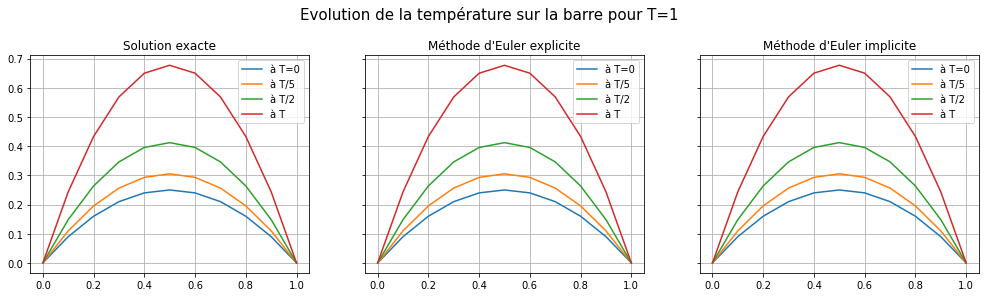

In [12]:
#
# Affichage des donnees pour validation et inter-comparaison
#
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (17,4), sharey ='all')

ax1.plot(x, U[:,0], label="à T=0")
ax1.plot(x, U[:, int(N_t/5)], label="à T/5")
ax1.plot(x, U[:, int(N_t/2)], label="à T/2")
ax1.plot(x, U[:,int(T/delta_t)-1], label="à T" )
ax1.legend()
ax1.grid(True)
ax1.set_title("Solution exacte")

ax2.plot(x, Ue[:,0], label="à T=0")
ax2.plot(x, Ue[:, int(N_t/5)], label="à T/5")
ax2.plot(x, Ue[:, int(N_t/2)], label="à T/2")
ax2.plot(x, Ue[:,int(T/delta_t)-1], label="à T" )
ax2.legend()
ax2.grid(True)
ax2.set_title("Méthode d'Euler explicite")

ax3.plot(x, Ui[:,0], label="à T=0")
ax3.plot(x, Ui[:, int(N_t/5)], label="à T/5")
ax3.plot(x, Ui[:, int(N_t/2)], label="à T/2")
ax3.plot(x, Ui[:,int(T/delta_t)-1], label="à T" )
ax3.legend()
ax3.grid(True)
ax3.set_title("Méthode d'Euler implicite")

fig.suptitle("Evolution de la température sur la barre pour T=" + str(T), fontsize = 15, y = 1.05)

plt.show()

### Schéma de discrétisation en temps du second ordre

<div style="background:LightGreen">
Par rapport aux schémas d'Euler, les changements sont du à la nécessité d'utiliser deux matrices creuses car on combine les deux schémas précédents, on doit donc résondre un système linéaire dont le terme de droite est issu d'un produit matriciel. Par conséquent, les matrices A et B sont modifiées. Et on a :<br><br>
$\hspace{4cm}\begin{equation*}
A' = 
\begin{pmatrix}
1-c          &\dfrac{c}{2} & 0         & \cdots & 0 \\
\dfrac{c}{2} &\ddots       &\ddots     & \ddots & \vdots \\
0            &\ddots       &\ddots     & \ddots & 0 \\
\vdots       &\ddots       &\ddots     & \ddots & \dfrac{c}{2} \\
0            & \cdots          &0             & \dfrac{c}{2} & 1-c 
\end{pmatrix}
\end{equation*}$
$\hspace{2cm}
\begin{equation*}
B' = 
\begin{pmatrix}
1+c          &\dfrac{-c}{2} & 0         & \cdots & 0 \\
\dfrac{-c}{2} &\ddots       &\ddots     & \ddots & \vdots \\
0            &\ddots       &\ddots     & \ddots & 0 \\
\vdots       &\ddots       &\ddots     & \ddots & \dfrac{-c}{2} \\
0            & \cdots          &0             & \dfrac{-c}{2} & 1+c 
\end{pmatrix}
\end{equation*}$    
    
<br>Le second membre de l'équation (la tendance) est donc moyenné sur deux instants : $\dfrac{\Delta t}{2}(F(X,t+1)+F(X,t))$.
<br> On peut résumer le schéma de Crank - Nicolson décentré ainsi :   $ \boxed{B'U^n=A'U^{n-1}+\dfrac{\Delta t}{2}(F^n+F^{n-1})}, \forall n \in [\![ 1, N_t ]\!]$
<br><br>
On aurait aussi pu utiliser un schéma centré pour réduire l'erreur à chaque pas.
</div>

In [13]:
def schema_cn(N, h, c, T, delta_t, U_cn) :
    """
    Fonction representant le tableau bidimensionnel [espace, temps] correspondant a la 
    solution en chaque point du maillage et a tout temps discret obtenue avec le schema 
    de Crank-Nicolson.
    Entrees:
    N: Nombre de points de discretisation en espace [int]
    h: Pas de maillage spatial [float]
    c: Nombre CFL [float]
    T: Temps final [float]
    delta_t: Pas de discretisation temporel [float]
    u0: condition initiale [array]
    Sortie:
    U_cn: Tableau bidimensionnel de la solution du schema de Crank-Nicolson evaluee en tout x et a tout temps t [float]
    """
    #
    # Création de la matrice A via une matrice creuse (interieur du domaine)
    #
    A = np.zeros((N-2, N-2))
    A[0,0] = 1 - c
    for i in range(1, N-2) :
        A[i,i] = 1 - c
        A[i,i-1] = c / 2
        A[i-1,i] = c / 2
    #
    # Création de la matrice B via une matrice creuse (interieur du domaine)
    #        
    B = np.zeros((N-2, N-2))
    B[0,0] = 1 + c
    for i in range(1, N-2) :
        B[i,i] = 1 + c
        B[i,i-1] = -c / 2
        B[i-1,i] = -c / 2
        
    #
    # Application du schéma sur les points interieurs
    #    
    #U_cn[:,0] = u0
    #U_cn[0,:] = 0
    #U_cn[N-1,:] = 0
    
    for t in range(1, int(T/delta_t)):
        U_cn[1:-1,t] = np.linalg.solve(B, np.dot(A, U_cn[1:-1,t-1]) + delta_t / 2 * (second_membre(np.arange(0,1+h,h)[1:-1],t*delta_t) + second_membre(np.arange(0,1+h,h)[1:-1],(t-1)*delta_t)))
    
    return U_cn

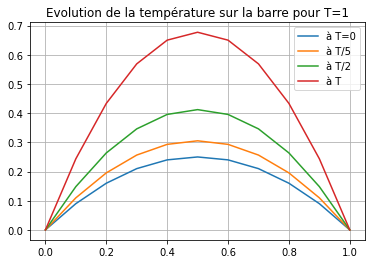

In [14]:
#
# La condition initiale est celle qui a été définie ci-dessus

#
# Deduction de la solution du schema de Crank-Nicolson en temps
#
U_cn      = np.zeros((N, int(T/delta_t)), dtype=float)
U_cn[:,0] = u0
Ucn               = schema_cn(N,h,c, T, delta_t, U_cn)
#
# Representation graphique a differents instants a choisir
#
x = np.linspace(0, 1, N)
plt.plot(x, Ucn[:,0], label="à T=0")
plt.plot(x, Ucn[:, int(N_t/5)], label="à T/5")
plt.plot(x, Ucn[:, int(N_t/2)], label="à T/2")
plt.plot(x, Ucn[:,int(T/delta_t)-1], label="à T" )
plt.legend()
plt.grid(True)
plt.title("Evolution de la température sur la barre pour T=" + str(T))
plt.show()

In [15]:
def ordre_discretisation_temps_cn(h, N, T):
    """
    Calcul de l'ordre de discretisation en temps
    Entrées : 
        h: pas de discretisation spatial  [float]
        N: nombre de points de discretisation en espace [int]
        T: temps final [float]
    Sortie : 
        time_step: pas de temps en loi log [float, array]
        erreur  : erreur en loi log[float, array]
    """
    time_step = np.zeros(10)
    error     = np.zeros(10)
    count     = 0
    
    for loop in range(20, 120, 10):
        delta = 1./loop
        c     = delta/(h**2)
        #
        # Initialisation pour la solution exacte
        #
        #u0       = np.zeros(N, dtype=float)
        u0 = np.array([-x*(x-1) for x in np.arange(0,1+h,h)])
        # A COMPLETER
        U_exacte = schema_exact(N, h, c, T, delta, u0)          
        #
        # Initialisation pour la solution numérique
        #
        U_cn   = np.zeros((N, int(T/delta)), dtype=float)
        #u0            = np.zeros(N, dtype=float)
        # A COMPLETER
        U_cn[:,0] = u0
        #
        #
        #
        U_cn      = schema_cn(N, h, c, T, delta, U_cn)
        error[count]     = math.log(erreur(U_exacte, U_cn, h))
        time_step[count] = math.log(delta) 
        count            += 1
        
    return time_step, error

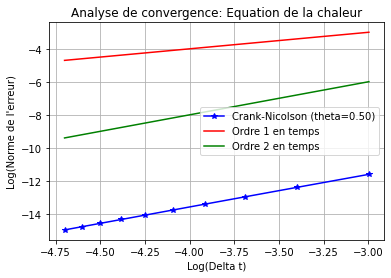

In [16]:
#
# Construction des elements pour l'analyse du schema
#
time_step, error  = ordre_discretisation_temps_cn(h, N, T)

#
# Creation de la figure
#
theta = 1/2
fig = plt.figure()
plt.plot(time_step,error,marker='*',color='blue',label='Crank-Nicolson (theta='"%3.2f"%theta+')')
plt.plot(time_step,1.*time_step,color='red',label='Ordre 1 en temps')
plt.plot(time_step,2.*time_step,color='green',label='Ordre 2 en temps')
plt.xlabel("Log(Delta t)")
plt.ylabel("Log(Norme de l'erreur)")
plt.title('Analyse de convergence: Equation de la chaleur')
plt.legend()
plt.grid(True)
plt.show()

<div style="background:LightGreen">
On obtient une convergence d'ordre 2 en temps (cf. les pentes sur la figure ci-dessus), ce qui était attendu pour la méthode de Crank - Nicolson.
</div>